In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset
import random
import numpy as np

def set_seed(seed: int):
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Numpy
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN (중요)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PyTorch 2.x (있으면 더 강력)
    torch.use_deterministic_algorithms(True, warn_only=True)

def subsample_dataset(dataset, num_samples, seed=42):
    torch.manual_seed(seed)
    indices = torch.randperm(len(dataset))[:num_samples]
    return Subset(dataset, indices)

def get_dataloaders(train_dataset, test_dataset, seed):
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        generator=g,
        num_workers=6,        
        pin_memory=True,      
        persistent_workers=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=6,        
        pin_memory=True,      
        persistent_workers=True
    )

    return train_loader, test_loader

In [3]:
SUBSAMPLE_SEED = 42

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])


full_train_dataset = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# 5,000개만 사용
train_dataset_small = subsample_dataset(
    full_train_dataset,
    num_samples=5000,
    seed=SUBSAMPLE_SEED
)


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm 

In [5]:
class CNN_CIFAR(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()

        self.features = nn.Sequential(
            # block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32 -> 16x16

            # block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16 -> 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

class MLP_CIFAR(nn.Module):
    def __init__(self, patch=2, hidden=1024, num_classes=100):
        super().__init__()
        self.patch = patch
        dim = 3 * patch * patch

        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
        )

        self.cls = nn.Linear(hidden, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch

        x = x.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, -1, C*p*p)

        h = self.net(x).mean(dim=1)
        return self.cls(h)

In [6]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [7]:
from tqdm.notebook import tqdm
import copy

def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(train_loader.dataset)

def kd_loss(student_logits, teacher_logits, T=2.0):
    return kl_loss(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)

def studygroup(
    model1,
    model2,
    optimizer1,
    optimizer2,
    train_loader,
    device,
    T=2.0
):
    model1.train()
    model2.train()

    train_loss1 = 0.0
    train_loss2 = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        logits1 = model1(x)
        logits2 = model2(x)

        pred1 = logits1.argmax(dim=1)
        pred2 = logits2.argmax(dim=1)

        correct1 = pred1 == y
        correct2 = pred2 == y

        # index 정의
        index1 = correct1 & ~correct2   # model1 
        index2 = ~correct1 & correct2   # model2 
        index3 = ~(index1 | index2)    

        # ----------------------
        # model1 update
        # ----------------------
        loss1 = torch.tensor(0.0, device=device)
        if index2.any():
            loss1 += kd_loss(
                logits1[index2],
                logits2[index2].detach(),
                T=T
            )
        if index3.any():
            loss1 += ce_loss(
                logits1[index3],
                y[index3]
            )

        loss1.backward()
        optimizer1.step()

        # ----------------------
        # model2 update
        # ----------------------
        loss2 = torch.tensor(0.0, device=device)
        if index1.any():
            loss2 += kd_loss(
                logits2[index1],
                logits1[index1].detach(),
                T=T
            )
        if index3.any():
            loss2 += ce_loss(
                logits2[index3],
                y[index3]
            )

        loss2.backward()
        optimizer2.step()

        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

    return (
        model1,
        model2,
        copy.deepcopy(model1.state_dict()),
        copy.deepcopy(model2.state_dict()),
        train_loss1 / len(train_loader),
        train_loss2 / len(train_loader)
    )

@torch.no_grad()
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2000
criterion = nn.CrossEntropyLoss()

cnn_master = CNN_CIFAR().to(device)
mlp_master = MLP_CIFAR().to(device)


In [9]:
def run_experiment(seed, model_type="CNN", epochs=500):
    set_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader = get_dataloaders(
        train_dataset_small,
        test_dataset,
        seed
    )

    if model_type == "CNN":
        model = copy.deepcopy(cnn_master).to(device)
    elif model_type == "MLP":
        model = copy.deepcopy(mlp_master).to(device)
    else:
        raise ValueError("Unknown model")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_curve = []
    acc_curve = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(
            model, optimizer, criterion, train_loader, device
        )

        acc = evaluate_accuracy(model, test_loader, device)

        train_curve.append(train_loss)
        acc_curve.append(acc)
        best_acc = max(best_acc, acc)

    return {
        "best": best_acc,
        "train_curve": np.array(train_curve),
        "test_curve": np.array(acc_curve)
    }

In [10]:
seeds = [0, 1, 2, 3, 4]
results_CNN = []
results_MLP = []

for seed in tqdm(seeds):
    out = run_experiment(seed, "CNN", epochs=2000)
    results_CNN.append(out)
    out = run_experiment(seed, "MLP", epochs=2000)
    results_MLP.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/geunseopark/anaconda3/envs/PGS_TORCH/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
def run_experiment_ssmo(seed, model1_type="CNN", model2_type="CNN", epochs=500):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader = get_dataloaders(
        train_dataset_small,
        test_dataset,
        seed
    )

    if model1_type == "CNN":
        model1 = copy.deepcopy(cnn_master).to(device)
    elif model1_type == "MLP":
        model1 = copy.deepcopy(mlp_master).to(device)
    else:
        raise ValueError("Unknown model1")

    if model2_type == "CNN":
        model2 = copy.deepcopy(cnn_master).to(device)
    elif model2_type == "MLP":
        model2 = copy.deepcopy(mlp_master).to(device)
    else:
        raise ValueError("Unknown model2")

    optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_curve1 = []
    acc_curve1 = []
    best_acc1 = 0.0
    train_curve2 = []
    acc_curve2 = []
    best_acc2 = 0.0

    for epoch in tqdm(range(epochs)):
        model1, model2, _, _, train_loss1, train_loss2 = studygroup(model1, model2, optimizer1, optimizer2, train_loader, device, T=2.0)
        
        acc1 = evaluate_accuracy(model1, test_loader, device)
        acc2 = evaluate_accuracy(model2, test_loader, device)

        train_curve1.append(train_loss1)
        acc_curve1.append(acc1)
        best_acc1 = max(best_acc1, acc1)
        
        train_curve2.append(train_loss2)
        acc_curve2.append(acc2)
        best_acc2 = max(best_acc2, acc2)

    return {
        "best1": best_acc1,
        "train_curve1": np.array(train_curve1),
        "test_curve1":  np.array(acc_curve1),
        "best2": best_acc2,
        "train_curve2": np.array(train_curve2),
        "test_curve2":  np.array(acc_curve2),
    }

In [12]:
seeds = [0, 1, 2, 3, 4]
results_CNN_CNN = []
results_MLP_CNN = []
results_MLP_MLP = []

for seed in tqdm(seeds):
    out = run_experiment_ssmo(seed, model1_type="CNN", model2_type="CNN", epochs=2000)
    results_CNN_CNN.append(out)
    out = run_experiment_ssmo(seed, model1_type="MLP", model2_type="CNN", epochs=2000)
    results_MLP_CNN.append(out)
    out = run_experiment_ssmo(seed, model1_type="MLP", model2_type="MLP", epochs=2000)
    results_MLP_MLP.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
import csv

# CSV 파일로 저장
with open('results/cifar100/experiment_results_cnn.csv',
          'w', newline='', encoding='utf-8') as f:

    fieldnames = ['best', 'train_curve', 'test_curve']
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()

    for r in results_CNN:
        r_copy = r.copy()
        r_copy['train_curve'] = r_copy['train_curve'].tolist()
        r_copy['test_curve'] = r_copy['test_curve'].tolist()
        writer.writerow(r_copy)

with open('results/cifar100/experiment_results_mlp.csv',
          'w', newline='', encoding='utf-8') as f:

    fieldnames = ['best', 'train_curve', 'test_curve']
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()

    for r in results_MLP:
        r_copy = r.copy()
        r_copy['train_curve'] = r_copy['train_curve'].tolist()
        r_copy['test_curve'] = r_copy['test_curve'].tolist()
        writer.writerow(r_copy)
        
with open('results/cifar100/experiment_results_cnn_cnn.csv',
          'w', newline='', encoding='utf-8') as f:

    fieldnames = ['best1', 'train_curve1', 'test_curve1', 'best2', 'train_curve2', 'test_curve2']
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()

    for r in results_CNN_CNN:
        r_copy = r.copy()
        r_copy['train_curve1'] = r_copy['train_curve1'].tolist()
        r_copy['test_curve1'] = r_copy['test_curve1'].tolist()
        r_copy['train_curve2'] = r_copy['train_curve2'].tolist()
        r_copy['test_curve2'] = r_copy['test_curve2'].tolist()
        writer.writerow(r_copy)

with open('results/cifar100/experiment_results_mlp_cnn.csv',
          'w', newline='', encoding='utf-8') as f:

    fieldnames = ['best1', 'train_curve1', 'test_curve1', 'best2', 'train_curve2', 'test_curve2']
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()

    for r in results_MLP_CNN:
        r_copy = r.copy()
        r_copy['train_curve1'] = r_copy['train_curve1'].tolist()
        r_copy['test_curve1'] = r_copy['test_curve1'].tolist()
        r_copy['train_curve2'] = r_copy['train_curve2'].tolist()
        r_copy['test_curve2'] = r_copy['test_curve2'].tolist()
        writer.writerow(r_copy)

with open('results/cifar100/experiment_results_mlp_mlp.csv',
          'w', newline='', encoding='utf-8') as f:

    fieldnames = ['best1', 'train_curve1', 'test_curve1', 'best2', 'train_curve2', 'test_curve2']
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    writer.writeheader()

    for r in results_MLP_MLP:
        r_copy = r.copy()
        r_copy['train_curve1'] = r_copy['train_curve1'].tolist()
        r_copy['test_curve1'] = r_copy['test_curve1'].tolist()
        r_copy['train_curve2'] = r_copy['train_curve2'].tolist()
        r_copy['test_curve2'] = r_copy['test_curve2'].tolist()
        writer.writerow(r_copy)

print("CSV 파일 저장 완료")

CSV 파일 저장 완료


In [14]:
# MLP-CNN Result

test_curves1 = np.stack([r["test_curve"] for r in results_CNN], axis=0)
# shape: (num_seeds, epochs)

mean_curve1 = test_curves1.mean(axis=0)
std_curve1 = test_curves1.std(axis=0)

best_mean1 = np.mean([r["best"] for r in results_CNN])
best_std1 = np.std([r["best"] for r in results_CNN])

test_curves2 = np.stack([r["test_curve"] for r in results_MLP], axis=0)
# shape: (num_seeds, epochs)

mean_curve2 = test_curves2.mean(axis=0)
std_curve2 = test_curves2.std(axis=0)

best_mean2 = np.mean([r["best"] for r in results_MLP])
best_std2 = np.std([r["best"] for r in results_MLP])

test_curves3 = np.stack([r["test_curve1"] for r in results_MLP_CNN], axis=0)
# shape: (num_seeds, epochs)

mean_curve3 = test_curves3.mean(axis=0)
std_curve3 = test_curves3.std(axis=0)

best_mean3 = np.mean([r["best1"] for r in results_MLP_CNN])
best_std3 = np.std([r["best1"] for r in results_MLP_CNN])

test_curves4 = np.stack([r["test_curve2"] for r in results_MLP_CNN], axis=0)
# shape: (num_seeds, epochs)

mean_curve4 = test_curves4.mean(axis=0)
std_curve4 = test_curves4.std(axis=0)

best_mean4 = np.mean([r["best2"] for r in results_MLP_CNN])
best_std4 = np.std([r["best2"] for r in results_MLP_CNN])

In [15]:
print(f"CNN mean: {best_mean1}")
print(f"CNN std: {best_std1}")
print(f"MLP mean: {best_mean2}")
print(f"MLP std: {best_std2}")
print(f"CNN_Ours mean: {best_mean4}")
print(f"CNN_Ours std: {best_std4}")
print(f"MLP_Ours mean: {best_mean3}")
print(f"MLP_Ours std: {best_std3}")

CNN mean: 0.30849999999999994
CNN std: 0.009038362683583795
MLP mean: 0.21342
MLP std: 0.001142628548566854
CNN_Ours mean: 0.3565
CNN_Ours std: 0.0023698101189757776
MLP_Ours mean: 0.23988
MLP_Ours std: 0.001135605565326273


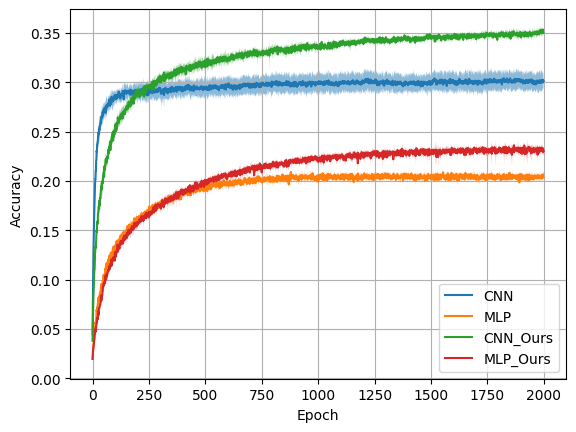

In [16]:
import matplotlib.pyplot as plt

epochs = np.arange(len(mean_curve1))

plt.plot(epochs[:], mean_curve1[:], label="CNN")
plt.fill_between(
    epochs[:],
    mean_curve1[:] - std_curve1[:],
    mean_curve1[:] + std_curve1[:],
    alpha=0.5
)
plt.plot(epochs[:], mean_curve2[:], label="MLP")
plt.fill_between(
    epochs[:],
    mean_curve2[:] - std_curve2[:],
    mean_curve2[:] + std_curve2[:],
    alpha=0.5
)
plt.plot(epochs[:], mean_curve4[:], label="CNN_Ours")
plt.fill_between(
    epochs[:],
    mean_curve4[:] - std_curve4[:],
    mean_curve4[:] + std_curve4[:],
    alpha=0.5
)
plt.plot(epochs[:], mean_curve3[:], label="MLP_Ours")
plt.fill_between(
    epochs[:],
    mean_curve3[:] - std_curve3[:],
    mean_curve3[:] + std_curve3[:],
    alpha=0.5
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()
